In [2]:
import src.models.oscar_ratings as oscar_ratings
import src.models.reviews_over_time as reviews_over_time
import src.models.actor_director_bias as actor_director
import src.models.oscar_bump as oscar_bump
import src.models.jury_bias as jury_bias

%load_ext autoreload
%autoreload 2

# Results

## 1. Ratings Comparison: Oscar Winners vs. Nominees

Are Oscar-winning movies generally better received than those that were only nominated?  
Let's start our analysis broadly by simply visualizing the distribution of average ratings bewteen oscar winners and nominees.  
For the start of our analysis, we consider a movie to be an oscar winner if a won an oscar in at least one category (and thus a nominee is one that didn't won any oscar in any category).  
Note that we use only nominees and winners and not other movies in order to control for the general quality of the movie which could be a cofounder variable.  
For instance an amateur movie done in one month is very likely to not win an oscar and have a bad rating.  
Considering only oscar winners and nominees, we insure that the movie is already of a certain quality standart.


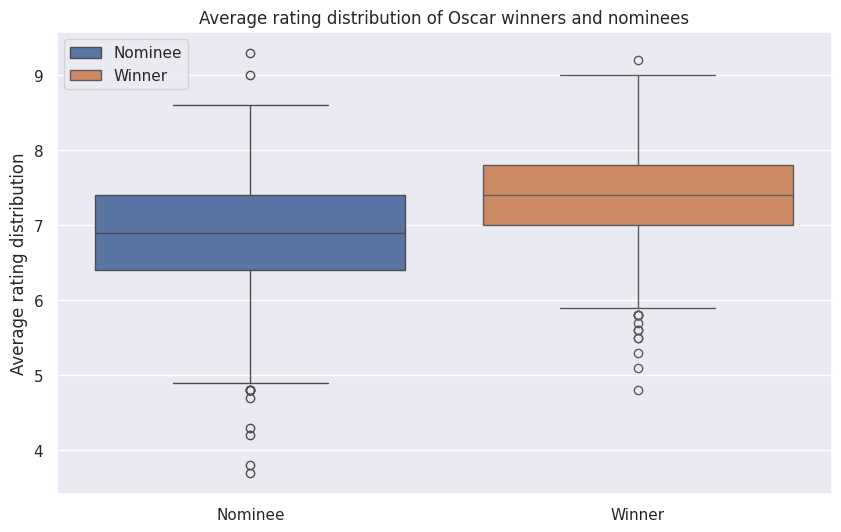

In [2]:
oscar_ratings.plot_winner_vs_nominees_ratings_all_cat()

At a first look, oscar winners seem to have an higher ratings on average.  
  
However, is is yet unclear if this observation is significant or not !  
So let's perform a t-test to verify that the distribution are indeed different.

In [3]:
oscar_ratings.print_ttest_winner_vs_nominees_ratings()

T-statistic:  14.984450324469712
P-value:  1.4587409398050492e-48


We observe that the p-value is very small ($<1\%$).  
Thus, we can reject the null hypothesis and initially conclude that the distribution of ratings between Oscar winners and nominees is significantly different.

Good news, the distribution are indeed significantly different.  
However, our analysis is very shalow for now and there are multiple factors that we didn't take into account like: *Ratings could depend on the released year (because of nostalgia of old movies) ?* or even not all movies have the same number of votes.  
In order to refine our analysis, we must take those factor into account.

Let's look at the distribution of ratings over the years (for winner and nominees).

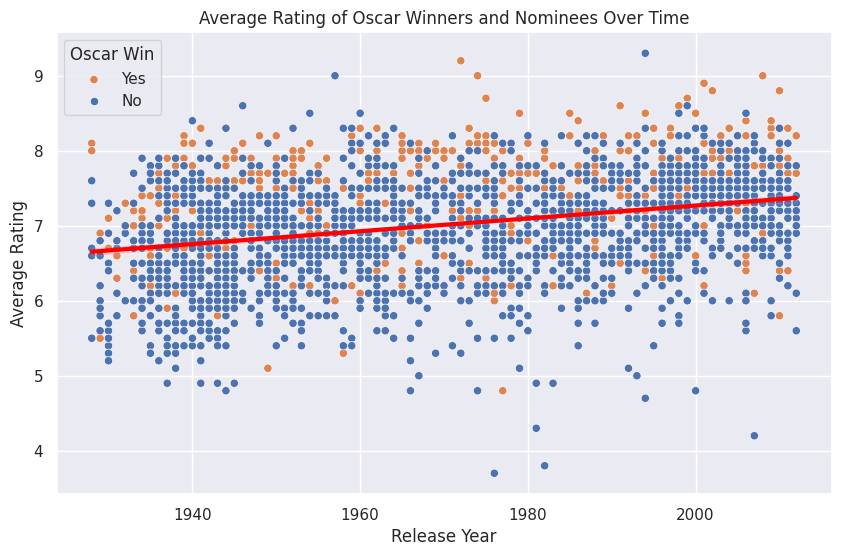

In [4]:
oscar_ratings.plot_ratings_over_release_year()

We indeed see that ratings seems to naturally increase with the release year.  
Let's confirm this observation with a regression. Here we regress the average ratings on the release year (`release`).

In [5]:
oscar_ratings.print_reg_ratings_release_year()

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     219.8
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           1.27e-47
Time:                        18:18:41   Log-Likelihood:                -2448.0
No. Observations:                2368   AIC:                             4900.
Df Residuals:                    2366   BIC:                             4911.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.8309      1.136     -8.651      0.0

As we can see, the factor on `release` is positive and has a p-value almost null which makes it very significant.  
Thus we can confirm our assumption that the average ratings of movies are naturally growing overtime.  
A possible interpretation could be that people prefer more recent movies.

Now let's look at the relation between the number of votes and the ratings.  

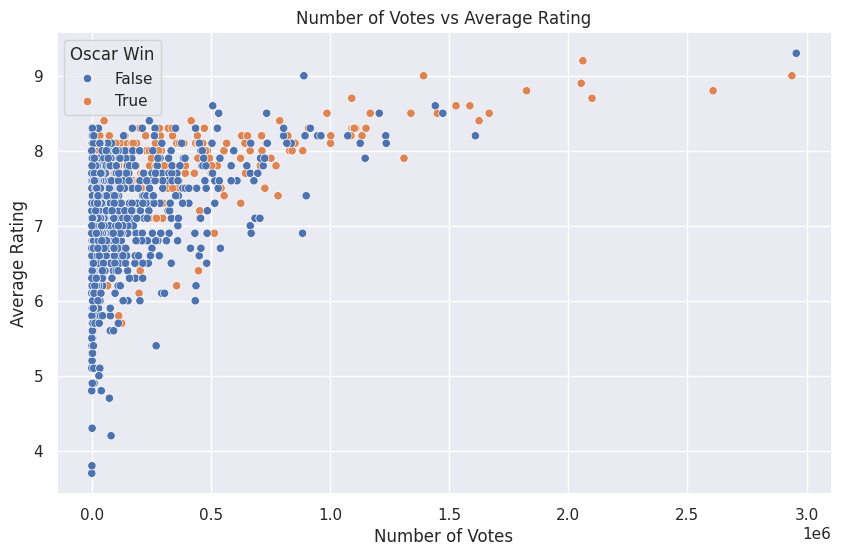

In [6]:
oscar_ratings.plot_numvotes_vs_ratings()

The relation between the number of votes and the average ratings seems to be non-linear.  
Let's use a log scale to better visualize it.

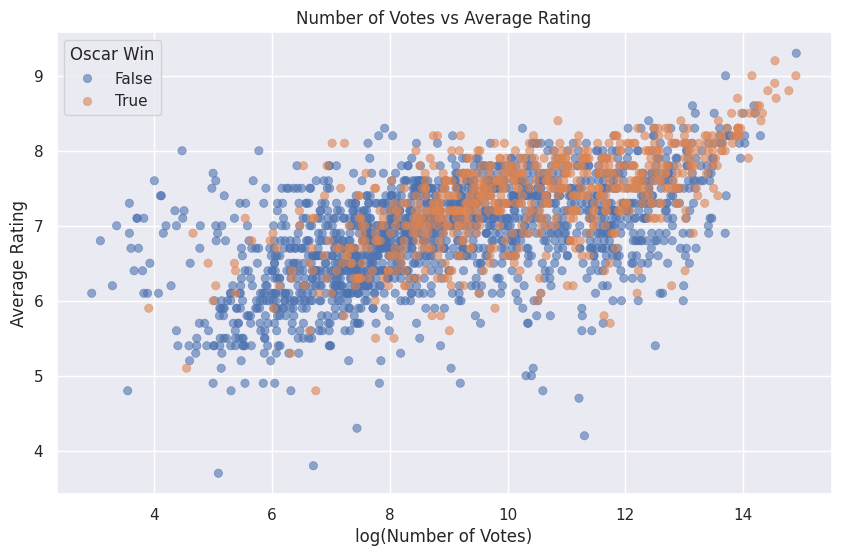

In [7]:
oscar_ratings.plot_log_numvotes_vs_ratings()

We see that the number of votes and the ratings seems to be correlated in an non linear manner.  
Let's confirm this by computing the Pearson and Spearman correlation. 

In [8]:
oscar_ratings.print_pearson_corr_ratings_numVotes()

Pearson correlation between numVotes and averageRating:  0.4300792311750075


In [9]:
oscar_ratings.print_spearman_corr_ratings_numVotes()

Spearman correlation between numVotes and averageRating:  0.5939721452138493


We notice that the Spearman correlation is positive and greater than the Pearson one. This aligns with our observations and is the sign of the non-linear dependency.   
Now, let's confirm the dependency between the average ratings and the log(number of votes) by performing a regression.

In [10]:
oscar_ratings.print_reg_ratings_log_numVotes()

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     1283.
Date:                Fri, 20 Dec 2024   Prob (F-statistic):          6.18e-225
Time:                        18:18:41   Log-Likelihood:                -2040.1
No. Observations:                2368   AIC:                             4084.
Df Residuals:                    2366   BIC:                             4096.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            5.3107      0.049  

We notice a positive coefficient on the log(number of votes).  
Also, the p-value is almost null which makes the coefficient very significant.  
This means that the log(number of votes) has a significant impact on the ratings and we must take that into account when studying the impact of winning an oscar.

In order to get the best results, we need to take those factor into account when studying the effect of winning an oscar.  
To do so, we first try to perform a regression on the average ratings taking into account those factors.  
Note that due to the very different distributions between the release year and the nlog(umber of votes), we have normalized the data to get better results from the regression.

In [11]:
oscar_ratings.print_reg_ratings_all()

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     418.4
Date:                Fri, 20 Dec 2024   Prob (F-statistic):          5.46e-218
Time:                        18:18:41   Log-Likelihood:                -1995.5
No. Observations:                2368   AIC:                             3999.
Df Residuals:                    2364   BIC:                             4022.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               6.9537    

From the regression and the almost null p-value on `any_win`, we notice that on average, winning an oscar will increase the rating of a movie by **0.21** rating units.

But all oscar categories are not worth the same, indeed winning an oscar for best actor or best picture are likely to have a significantly different impact of the ratings.  
So, let's study the causal effect on ratings of winning an oscar for each category.  

To do so we build a bipartit graph between oscar nominees (control group) and oscar winners (treated group).  
We add an edge between two movies if they have been released the same year (this allows to control for the effect of release year on the ratings).  
Also, we weight each edge by the number of votes difference. And then we create our matching by minimizing the weights. This allows to minimize the influence of the number of votes in our analysis.

However, we must also take into account the fact that a movie might have won an oscar in a category by nominated in another one. Thus, to avoid a bias, we must remove the nominees entries for such movies.

Also, because we study the causal effect of winning an oscar in a single category, we must remove movies that won multiple oscars.

Finally, we filter out categories for which we cannot create enough pairs.  
In our case, we impose a minimum of 10 pairs to get meaningful results.

In [12]:
oscar_ratings.print_causal_effect_for_base_cat()

Causal effect for category special effects: 0.5333333333333333
Causal effect for category actress in a leading role: 0.4055555555555554
Causal effect for category actor in a supporting role: 0.33749999999999997
Causal effect for category costume design: 0.3230769230769231
Causal effect for category sound recording: 0.30909090909090897
Causal effect for category music (song): 0.2823529411764706
Causal effect for category foreign language film: 0.2727272727272728
Causal effect for category documentary (feature): 0.2600000000000002
Causal effect for category music (scoring of a musical picture): 0.2333333333333333
Causal effect for category actress in a supporting role: 0.1571428571428571
Causal effect for category actor: 0.13076923076923092
Causal effect for category actress: -0.055555555555555504
Causal effect for category music (original song): -0.07333333333333349


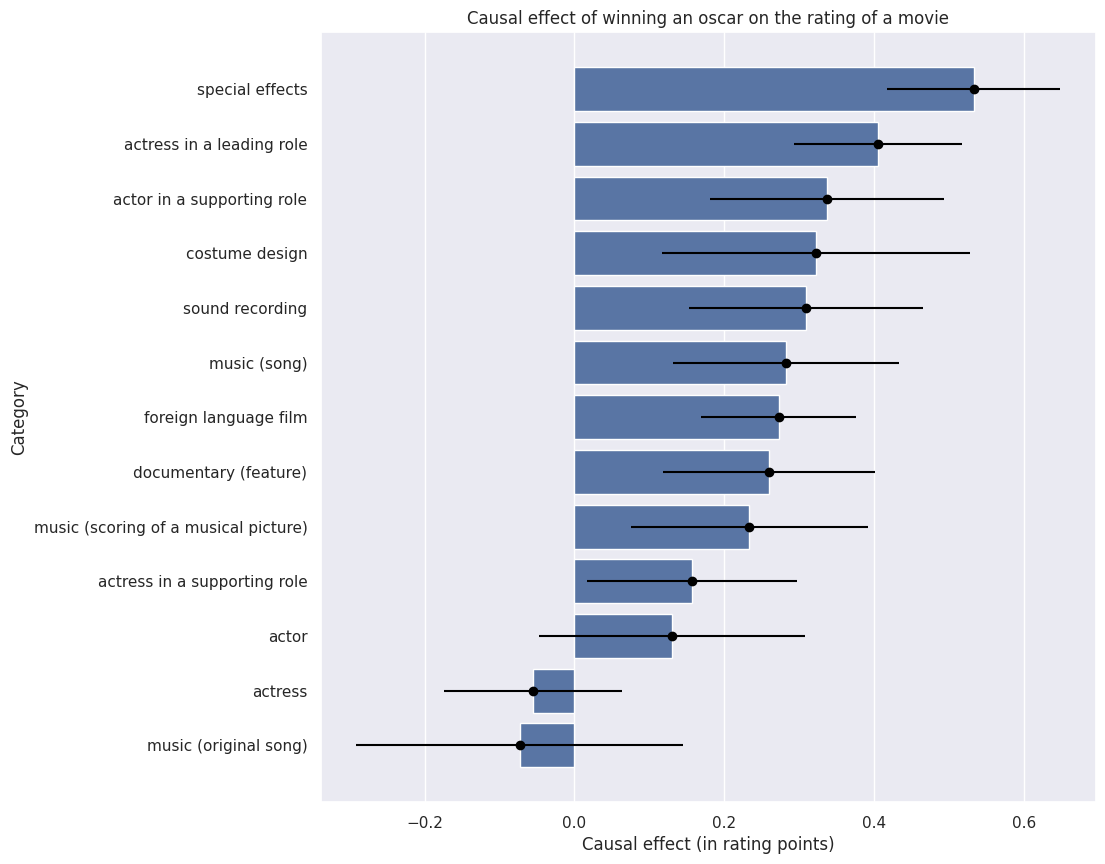

In [13]:
oscar_ratings.plot_causal_effect_of_base_cat()


Using this approach, we are able to determine the causal effects of only a few categories due to the restrictions of our pipeline.  
We for instance notice the important impact of winning an oscar in special effect which on average increases ratings by 0.53 rating units.

However, there are still many categories for which we weren't able to get the effect.  
Indeed, let's check all the categories for which we have more than 10 entries.


In [14]:
oscar_ratings.print_oscar_categories(min_samples = 10)

Category: actor in a supporting role, Number of samples: 319
Category: directing, Number of samples: 316
Category: actress in a supporting role, Number of samples: 315
Category: film editing, Number of samples: 308
Category: art direction, Number of samples: 223
Category: cinematography, Number of samples: 210
Category: best picture, Number of samples: 209
Category: actress, Number of samples: 191
Category: actor, Number of samples: 188
Category: sound, Number of samples: 178
Category: costume design, Number of samples: 170
Category: music (original score), Number of samples: 165
Category: sound recording, Number of samples: 160
Category: music (song), Number of samples: 160
Category: actress in a leading role, Number of samples: 150
Category: music (original song), Number of samples: 145
Category: actor in a leading role, Number of samples: 140
Category: cinematography (black-and-white), Number of samples: 133
Category: documentary (feature), Number of samples: 133
Category: foreign l

We see that many categories belong to the same area, it would be nice if we could group them under broader categories.  
To help us create category groups, we will make use of the K-means algorithm.

Concretely, we embed the categories as vectors and ten run k-means for different value of k.  
Given that we only have a few number of samples, the sum of squared errors in functions of k doesn't yield a nice elbow.  
We thus choose the best k based on a manual inspection of the clusters. This yields an optimal k of 12.  
> ⚠️ For this part to work, you must have the spacy english nlp model installed. ⚠️  
> You can install it with the following command: `python -m spacy download en_core_web_md `

In [15]:
optimal_k = 12
oscar_ratings.print_clusters(optimal_k)

Cluster 0:
art direction, dance direction, art direction (black-and-white), art direction (color), 

Cluster 1:
sound recording, outstanding motion picture, best motion picture, sound, best picture, visual effects, sound effects editing, sound editing, sound mixing, 

Cluster 2:
directing, outstanding production, special effects, writing (screenplay—based on material from another medium), writing (story and screenplay—written directly for the screen), writing (story and screenplay—based on factual material or material not previously published or produced), writing (screenplay based on material from another medium), writing (screenplay written directly for the screen), writing (screenplay based on material previously produced or published), 

Cluster 3:
actress in a supporting role, actor in a supporting role, actress in a leading role, actor in a leading role, 

Cluster 4:
writing (original story), writing (screenplay), cinematography (color), writing (original screenplay), writing (or

From a first observation, it seems that broader categories like writing or music stand out.  
Now, let's visualize the clusters. To do so, we perform a dimensionality reduction using the PCA method.

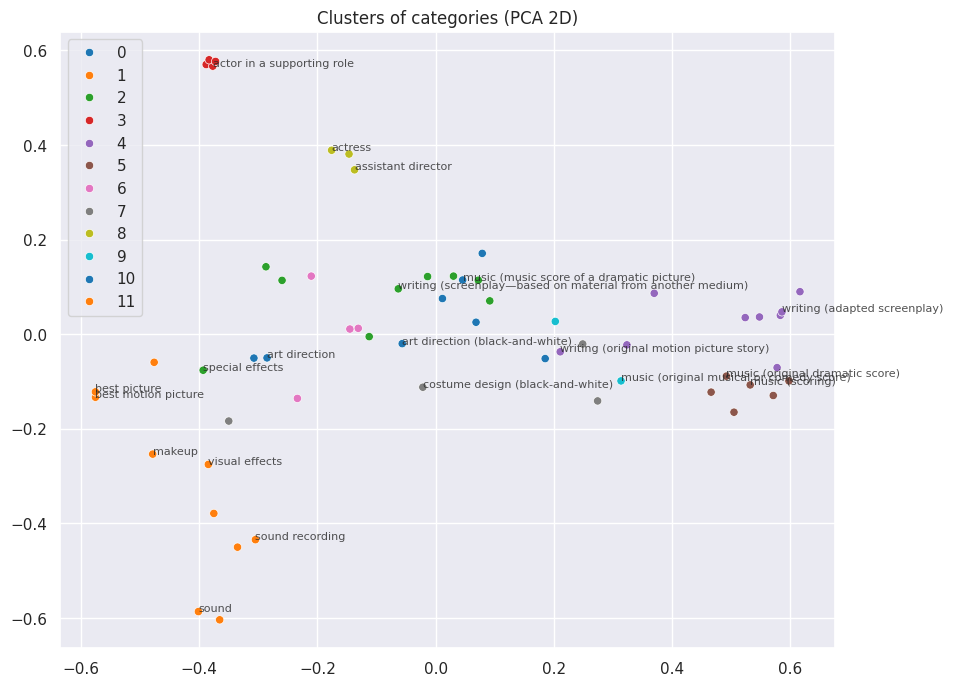

In [16]:
oscar_ratings.plot_clusters_2d(optimal_k)

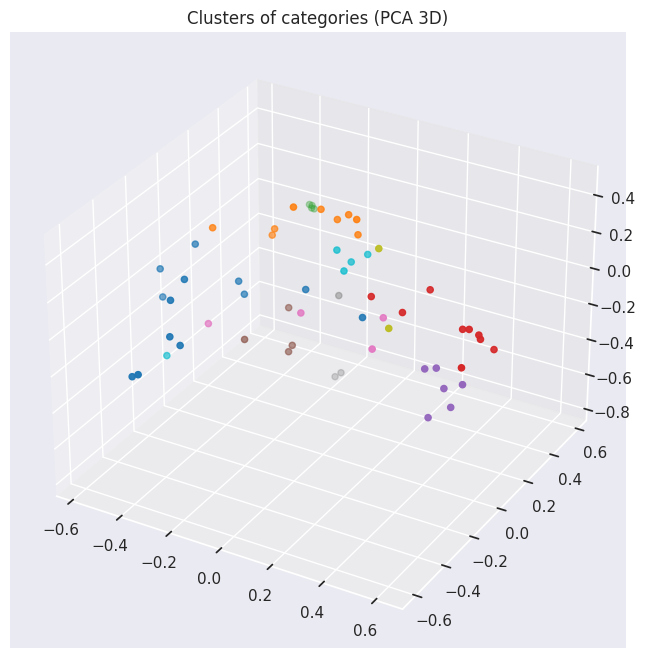

In [17]:
oscar_ratings.plot_clusters_3d(optimal_k)

Our clustering looks pretty good. However, from a human analysis, we can still see some intuitivly "mis-labeled" categories.  
For instance, it would make more sense for the *actor* category to be grouped with the other acting categories rather than the costume ones (as it is right now).  
Thus, thanks to the relatively few number of datapoints, we do a quick manual clean-up based on the clusters above. 
We end up with the following clusters:

Cluster 0:  **Direction**  
`
art direction, art direction (black-and-white), art direction (color), directing, assistant director, dance direction,
`

Cluster 1:  **Writing**  
`
writing (original story), writing (screenplay), writing (original screenplay), writing (original motion picture story), documentary (feature), writing (motion picture story), writing (story and screenplay), writing (screenplay—based on material from another medium), writing (story and screenplay—written directly for the screen), writing (story and screenplay—based on factual material or material not previously published or produced), writing (screenplay based on material from another medium), writing (screenplay written directly for the screen), writing (screenplay based on material previously produced or published), writing (adapted screenplay), 
`

Cluster 2:  **Best picture**  
`
outstanding production, outstanding motion picture, best motion picture, best picture, 
`

Cluster 3:  **Music**  
`
music (song), music (scoring), music (original score), music (scoring of a musical picture), music (music score of a dramatic picture), music (music score of a dramatic or comedy picture), music (original song), music (scoring of music—adaptation or treatment), music (music score—substantially original), music (song—original for the picture), music (original dramatic score), music (original musical or comedy score), 
`

Cluster 4:  **Sound**  
`
sound recording, sound, sound effects editing, sound editing, sound mixing, 
`

Cluster 5:  **Acting**  
`
actor, actress, actress in a supporting role, actor in a supporting role, actress in a leading role, actor in a leading role,  
`

Cluster 6:  **Cinematography**  
`
cinematography, cinematography (color), cinematography (black-and-white), 
`

Cluster 7:  **Costume**  
`
makeup, costume design (color), costume design (black-and-white), costume design, 
`

Cluster 8:  **Effects**  
`
special effects, visual effects, 
`

Cluster 9:  **Editing**  
`
film editing, foreign language film, animated feature film, 
`


In [18]:
oscar_ratings.print_causal_effect_for_new_cat()

Causal effect for category effects: 0.445
Causal effect for category cinematography: 0.41904761904761906
Causal effect for category sound: 0.4049999999999998
Causal effect for category costume: 0.31249999999999994
Causal effect for category editing: 0.3078947368421053
Causal effect for category writing: 0.1865853658536587
Causal effect for category direction: 0.08076923076923083
Causal effect for category acting: 0.07863247863247862
Causal effect for category music: 0.026027397260273977


We can now study the causal impact of winning an oscar in those broader categories.

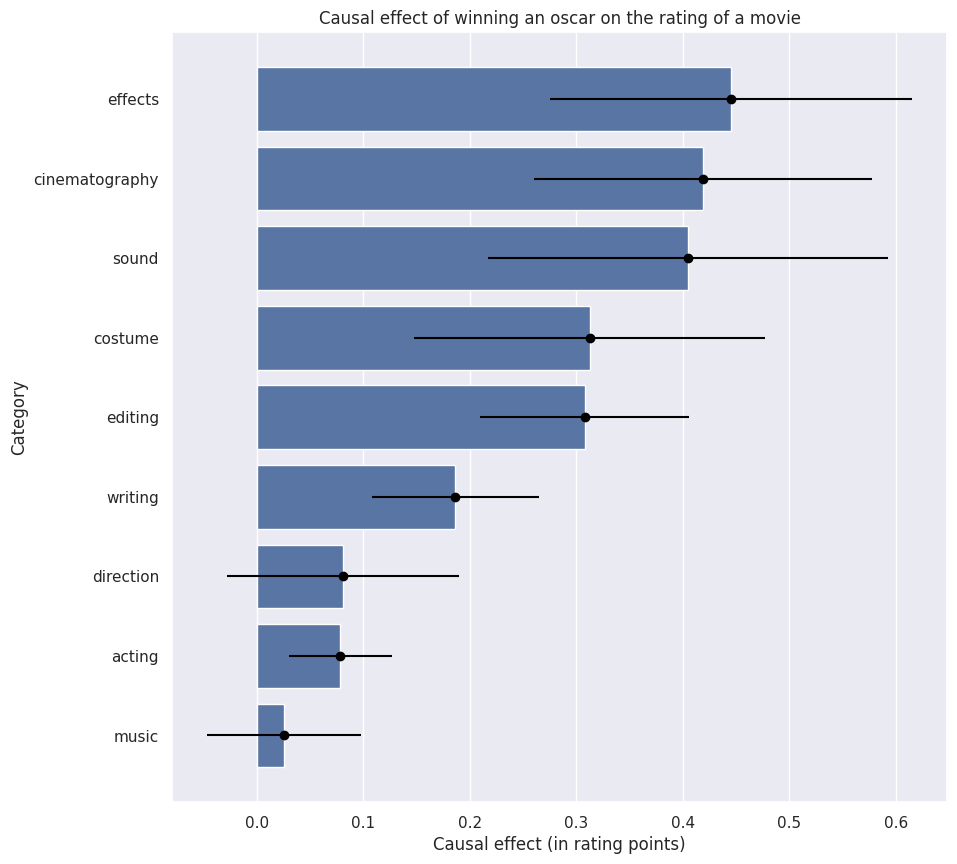

In [19]:
oscar_ratings.plot_causal_effect_of_new_cat()

We notice that the most influent categories are the one related to the effects, cinematography and sound.  
Note also that for the best picture related categories, we still don't have enough independent points to establish a causal relationship.  
Thus for this category, we'll have to perform further analysis.

Finally, we can also look at the distribution of ratings depending of the number of oscars won.  
Intuitively, we should see higher ratings for movie with multiple oscars.

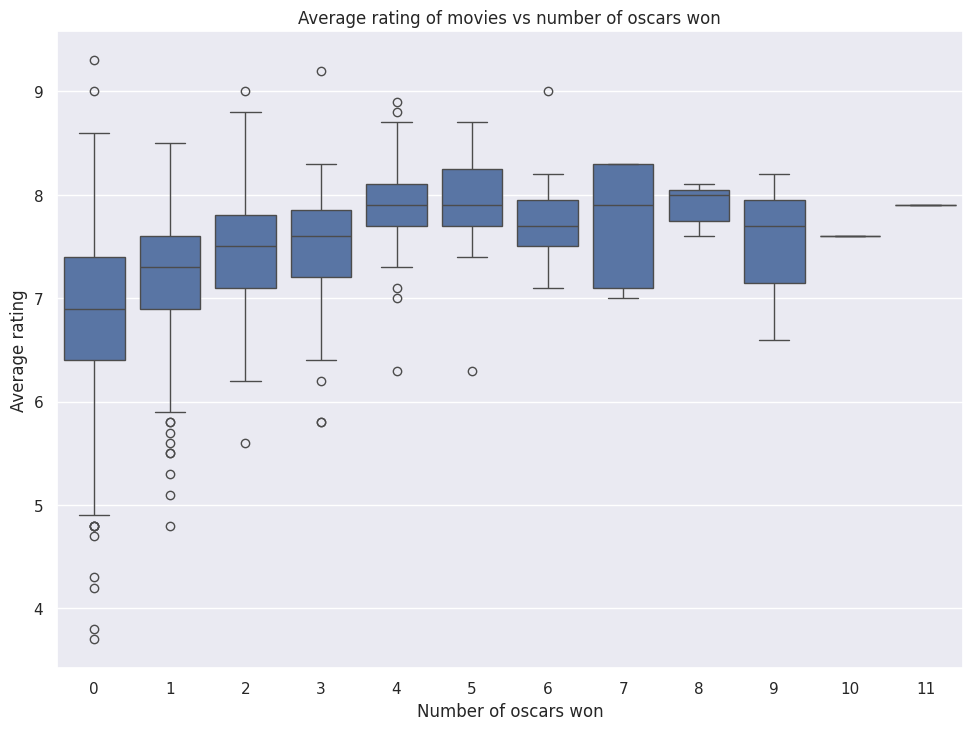

In [20]:
oscar_ratings.plot_ratings_vs_nb_oscars()

We notice that the distribution follows our expectations by increasing in the number of oscars won.  
This increase seems to be very present for the first five oscars and then it stabilizes.

## 2. Ratings Over Time: Do Oscar Winners "Age Well"?

In order to quantify the "sentiment" of the reviews (positive/negative), we use an open source sentiment analysis tool called "vaderSentiment", which computes the "compound score" of each movie review. The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules of the tool, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This useful metric gives a single unidimensional measure of sentiment for a given sentence.

How do review trends evolve over time after the Oscar ceremony? Is there a noticeable "hype effect" surrounding the awards?

To investigate this, we can analyze the distribution of positive and negative reviews over time. By examining how these proportions change in the months following the ceremony, we can determine whether the awards create a lasting impact or if public sentiment stabilizes quickly after the initial buzz.

Let’s plot and analyze the evolution of these distributions to gain deeper insights into the post-ceremony dynamics. Let's start by comparing all the positive and negative review scores:

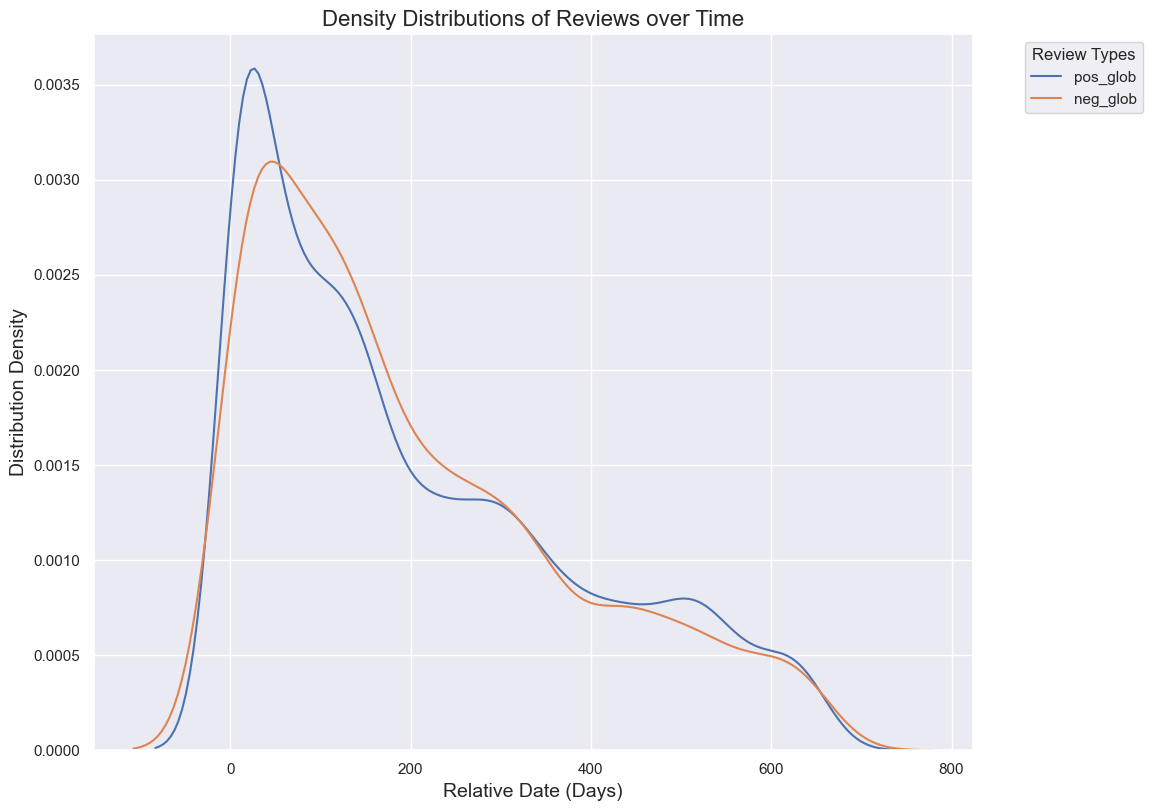

In [19]:
reviews_over_time.plot_compound_scores_global("pos_glob", "neg_glob")

In [20]:
reviews_over_time.print_ks_test_review_dates("pos_glob", "neg_glob")

KS Statistic: 0.03667226935185702, p-value: 0.004893739097848313


We observe that the distribution of positive reviews spikes immediately after the ceremony, whereas negative reviews are more evenly distributed throughout the first year. After one year, the two distributions converge, becoming quite similar.

This suggests that many positive reviews are posted right after of the Oscar ceremony when the "hype" is still present, reflecting the excitement and approval generated by the awards. On the other hand, negative reviews seem to decrease more gradually over time, indicating a slower decline in critics compared to the initial burst of positivity.

The two-sample Kolmogorov-Smirnov test, which compares the underlying continuous distributions F(x) and G(x) of two independent samples, also yields a small p-value (p < 0.05). This result leads us to reject the null hypothesis, which assumes that the two distributions are similar.

This suggest that there is a significant difference between the distributions, reinforcing the idea that the sentiment dynamics for the two samples are distinct.

Now, let's compare the positive and negative review scores for non-winning movies:

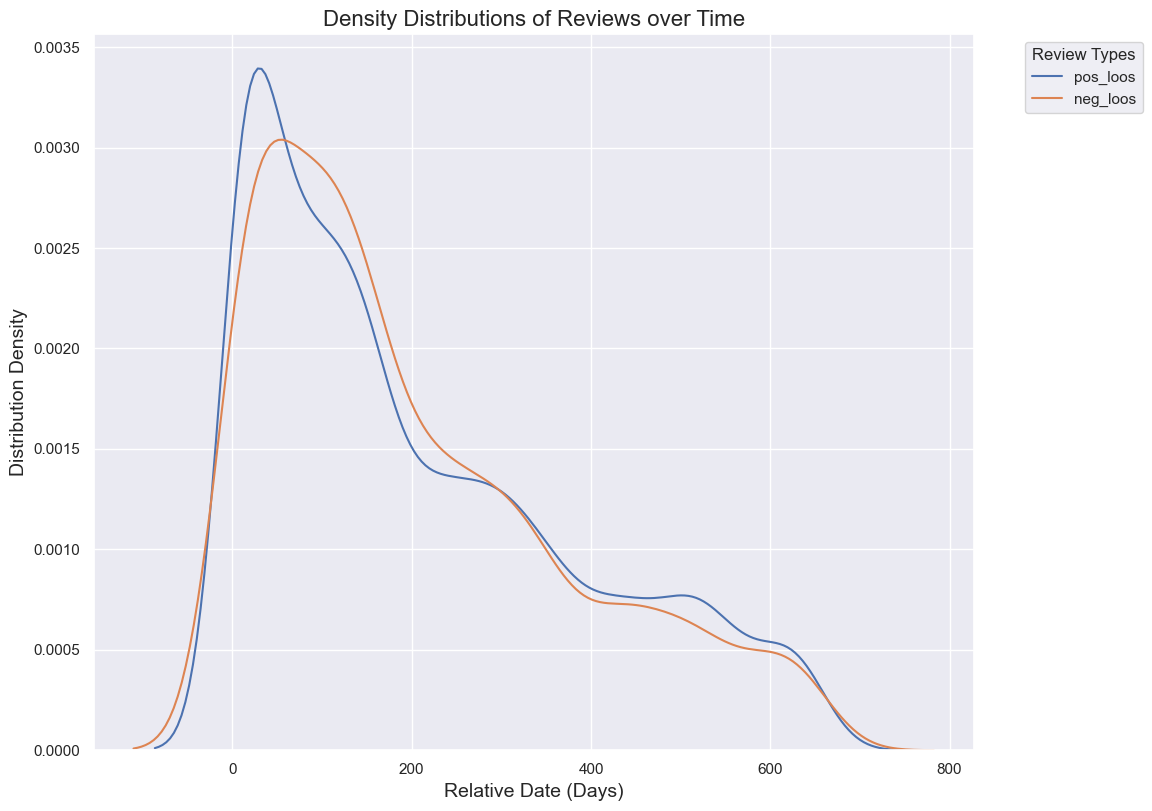

In [21]:
reviews_over_time.plot_compound_scores_global("pos_loos", "neg_loos")

In [22]:
reviews_over_time.print_ks_test_review_dates("pos_loos", "neg_loos")

KS Statistic: 0.02806726808951503, p-value: 0.10689688658378885


It seems that the difference between the distributions is less significant in this case, particularly for the losing movies, as suggested by the Kolmogorov-Smirnov (KS) test. The test indicates that we cannot reject the null hypothesis (P-Value bigger that 0.05), meaning we cannot confirm that the distributions for positive and negative reviews are different.

Although the plot shows a small spike in positive reviews, similar to the previous patterns observed, the KS test suggests that both positive and negative review numbers decay over time in a similar manner for the losing movies. This implies that, for these films, the review trends for both types of sentiment follow a comparable pattern over time.

Is it also the case for winning movies? Let's plot the positive and negative review scores for winning movies this time and compare the results:

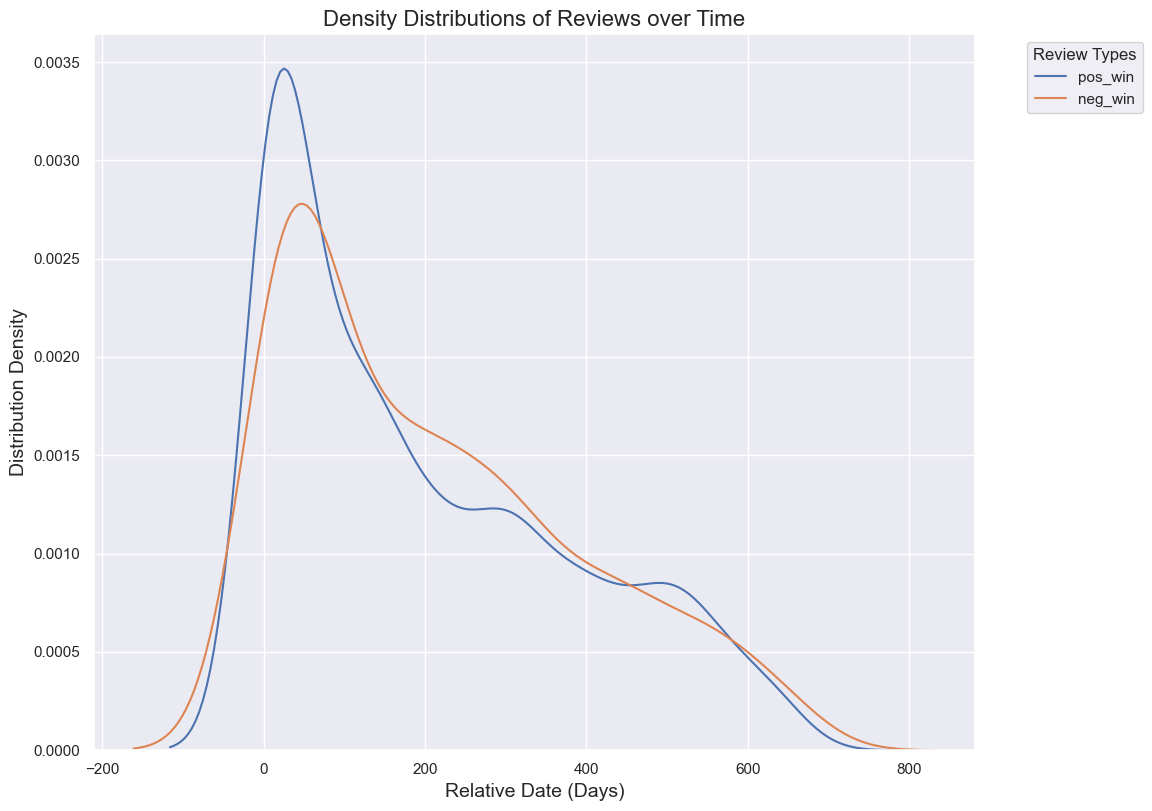

In [23]:
reviews_over_time.plot_compound_scores_global("pos_win", "neg_win")

In [24]:
reviews_over_time.print_ks_test_review_dates("pos_win", "neg_win")

KS Statistic: 0.08273615873853278, p-value: 0.010689552899039504


For the winning movies, the Kolmogorov-Smirnov (KS) test yields a p-value of 0.011. Unlike the case with losing movies, this result indicates that we can reject the null hypothesis at a 5% significance level, suggesting that the distributions of positive and negative reviews for winning movies are significantly different.

Examining the plot, it appears that the positive reviews show a higher and more sustained spike compared to negative reviews, particularly around the event of the Oscar ceremony (day 0). While both distributions exhibit a decay over time, the differing trends imply that winning movies tend to garner a relatively higher proportion of positive reviews in the period surrounding the Oscars. This could be attributed to the increased visibility and acclaim associated with the win, which may lead to a stronger positive bias in reviews.

In contrast to losing movies, for which the sentiment patterns over time were more comparable, this finding highlights how the prestige of an Oscar win can distinctly influence the compound score dynamics of reviews over time.

## 3. Impact of High-Profile Actors/Directors on Oscar Wins

Do Oscar judges, or the audience favor any high profile director or actor? e.g., are some movies winning oscars despite having a low average rating just because some popular people played in it?
This is the question we will be answering to in this section. We divide our approach for both actors and directors

To estimate how popular someone was at the year of the given oscar ceremony, we set a 'high profile score' as the mean of all the box office revenue the person has participated in before the oscar ceremony.

In [4]:
df_Q3, df_actor = actor_director.load_data_Q3()
#for the first part, we only consider the nominated movies
df_nominated = df_Q3[df_Q3['nominated'] == 1].copy()

### Directors

As a quick check, do we see the same names when displaying the directors with the highest profile scores and the ones that won the most oscar ?

In [5]:
first_year, last_year, director_revenue_year = actor_director.compute_profile_score(df_nominated)

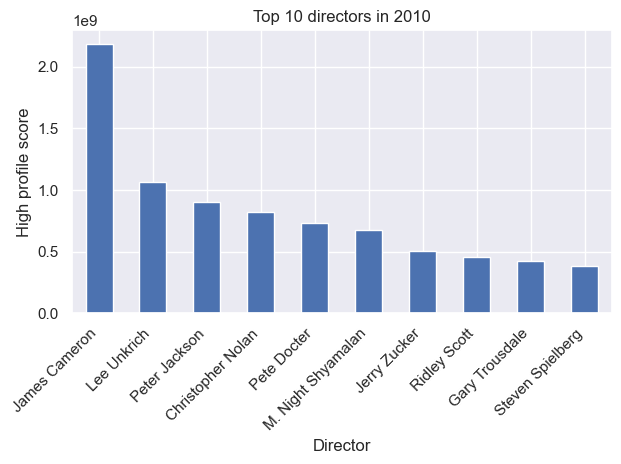

In [6]:

actor_director.plot_top_directors(director_revenue_year, 2010, 10)

In [7]:
actor_director.count_won_oscar(df_nominated)

111 directors have won 0 Oscars
40 directors have won 1 Oscars
3 directors have won 2 Oscars
Directors who have won more than 1 Oscar: Clint Eastwood Francis Ford Coppola Vincente Minnelli


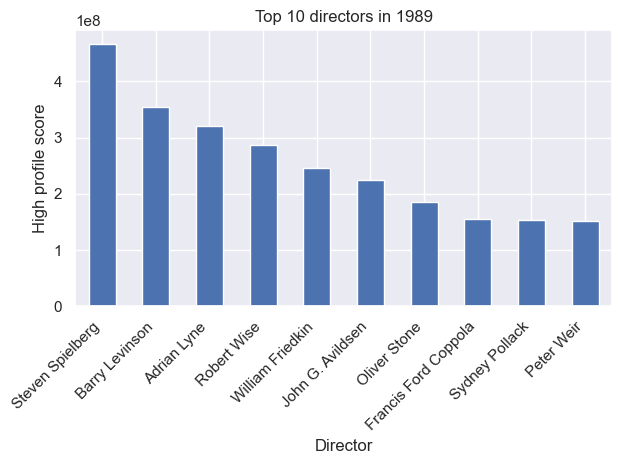

In [8]:
actor_director.plot_top_directors(director_revenue_year, 1989, 10)

As we can see, we can observe some names in common depending on the year, like Coppola who was in the top in 1989. But it is too early to draw any conclusion.



If each year, we sort the nominees by average ratings and by 'high profile score' in descending order, we see that the distributions are quite similar and heavy-tailed: oscar winning-movies are thus well rated and directed by a popular director.


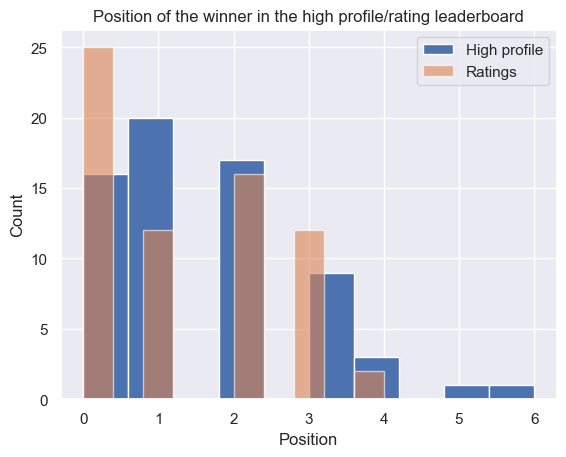

In [6]:
winner_position_profile, winner_position_rating = actor_director.plot_winner_position(df_nominated)

To reinforce our intuition, we can perform a statistical test to decide whether there is a significant difference between these 2 distributions at $\alpha = 5\%$:

$$
H_0: \mathcal{D}_{\text{ratings}} = \mathcal{D}_{\text{profiles}}
$$

$$
H_1: \mathcal{D}_{\text{ratings}} \ne \mathcal{D}_{\text{profiles}}
$$


In [7]:
# This is a first proof that these metrics are correlated!
pval = actor_director.compare_distribution(winner_position_profile, winner_position_rating)

p value = 0.28297678122945064
fail to reject the null hypothesis


There are obviously way less oscar-winning movies than there are movies overall, which might bias our analysis. If only there was a statistical method that could prevent that... Wait, I think we saw something like propensity score in ADA. Let's use it!

We will restrict our analysis by matching winning oscar and non-winning oscar movies together. This matching aims at connecting two movies with similar director profile score.


Optimization terminated successfully.
         Current function value: 0.503701
         Iterations 5
Average rating of oscar-winning movies: 7.913, Other nominees: 7.604
Mean difference on each pair: 0.27
p-value: 0.001992388286970469


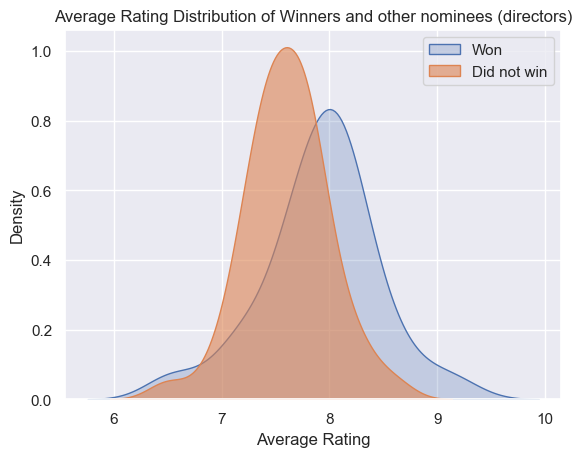

In [8]:
actor_director.match_and_plot(df_nominated)

Things are clearer now! As we can see by comparing the same amount of movies in both categories, we can clearly see that the oscar-winning movies have higher average ratings so the jury is not biased towards some directors independently of ratings ! The low p-value on the following statistical test verifies our observations:

$$
H_0: \mathcal{D}_{\text{ratings | loser}} = \mathcal{D}_{\text{ratings | winner}}
$$

$$
H_1: \mathcal{D}_{\text{ratings | loser}} \ne \mathcal{D}_{\text{ratings | winner}}
$$

On average, for each pair, the movie that won an oscar got a higher 0.254 higher rating.

### Actors

We will now conduct the same analysis steps but for actors. The 'high profile score' of an actor is given by the sum of all revenues of the movies the actor is known for (see the `knownForTtitles` feature in IMDB). This measure is time independent.

 We could expect to see an inverse phenomenon: the audience might be biased towards their favorite actors and give good ratings even if the jury does not consider that the movie deserves an oscar. In fact, an actor is more prone to familiarize an audience as he directly appears in the movie and generates more emotion.

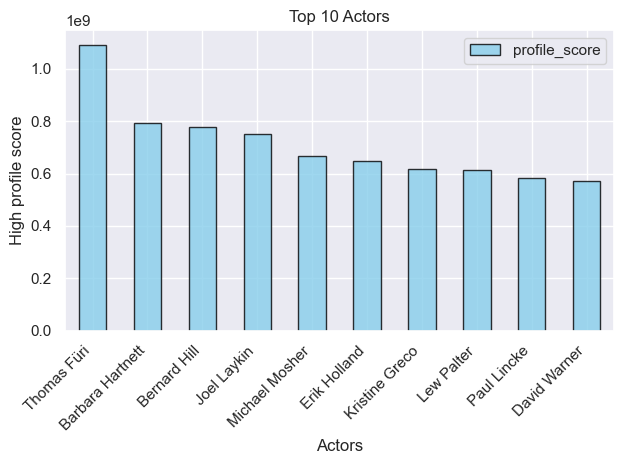

In [9]:

actor_director.plot_top_actors(df_actor, 10)

In [4]:

actor_director.count_won_oscar_actor(df_actor)

18892 actors have won 0 Oscars
806 actors have won 1 Oscars
41 actors have won 2 Oscars
2 actors have won 3 Oscars
Actors who have won more than 2 Oscars: Kenneth Utt Peter Dukelow


This time, we do not see any name in common.

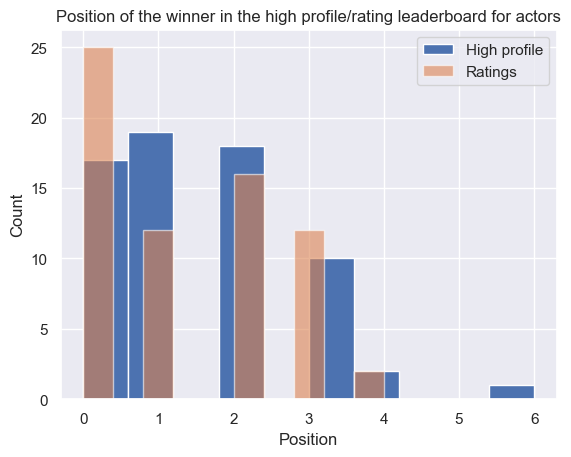

p value = 0.4450367761844667
fail to reject the null hypothesis


In [11]:
winner_position_profile, winner_position_rating = actor_director.plot_winner_position_actors(df_nominated, first_year, last_year)
pval = actor_director.compare_distribution(winner_position_profile, winner_position_rating)

As we can see, the p-value is even higher than with directors. This mean that our profile score, based on revenue and the ratings are even more correlated. Last but not least, what do we observe after performing our propensity score matching?

Optimization terminated successfully.
         Current function value: 0.495395
         Iterations 5
Average rating of oscar-winning movies: 7.913, Other nominees: 7.702
Mean difference on each pair: 0.207
p-value: 0.06593392019100348


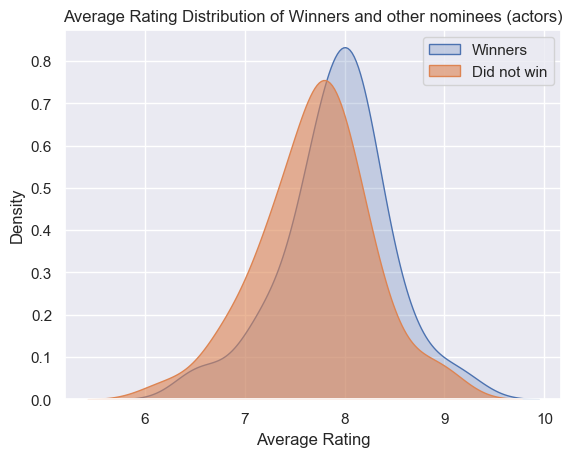

In [12]:

actor_director.match_and_plot_actor(df_nominated)

This time, we get a p-value of 0.066. Despite being low, it showcases that the distribution are similar as we can see on the plot. This could indicate a slight bias on the side of the audience: the lack of difference highlights that the jury is able to draw a difference between a movie that deserves an oscar and movies that do not but the audience does not as people can give a good rating just because an actor that they like played in the movie.

## Bias towards nomination

As explained at the beginning of the datastory, the jury who nominate is the same as the one who decides who wins the oscar, so what if the jury's bias was already present in the nomination?

Optimization terminated successfully.
         Current function value: 0.166342
         Iterations 7
Average rating of nominated movies: 7.673, Other movies: 6.083
Mean difference on each pair: 1.138
p-value: 9.188820347530082e-71


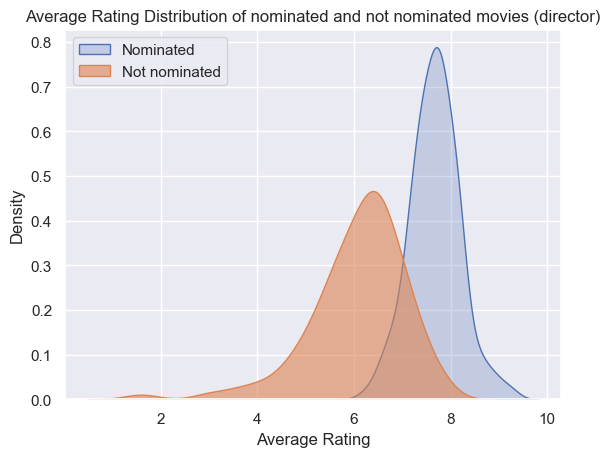

In [13]:
actor_director.match_and_plot_nominated(df_Q3)

Optimization terminated successfully.
         Current function value: 0.167325
         Iterations 7
Average rating of nominated movies: 7.673, Other movies: 6.372
Mean difference on each pair: 1.185
p-value: 3.8051604270092195e-57


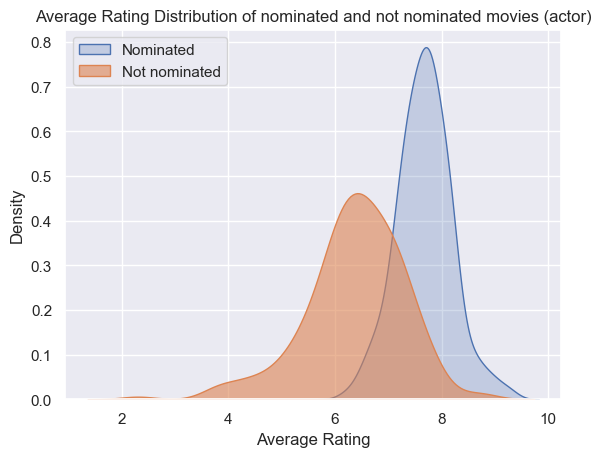

In [14]:
actor_director.match_and_plot_nominated_actor(df_Q3)

After matching on both actors and directors, we see that, even with similar profile scores, the movies that are not nominated have lower ratings on average. This gap is more pronounced than the one we observed among the nominated movies as the average difference between two pairs is 1.13

This confirms that the jury is not biased.

## 4. The Oscar Bump: Rating and Review Increases Post-Win

How does the public react when a movie is nominated for an Oscar? 

We gathered the IMDb reviews of all the movies nominated for the "best picture award" and filtered out the ones that were published too early before the nomination date (more that 2 months before the nomination) and too late after the ceremony date (more that 2 months after the ceremony). This leaves us with reviews published in the short period of time around the "Oscar window" (nomination and ceremony generally 2 months later). Our goal with this particular dataset is to determine if trends in the number or reviews and general opinion emerge from an Oscar nomination 

We used the "VaderSentiment" analysis tool in order to compute the "compound score" of each review. A positive review (in terms of words) will have a positive compound score (from 0 to 1) and a negative one will have a negative score (from -1 to 0).

To start our analysis, let us first visualize the distribution of the compound score for the reviews published before and after the nomination: 

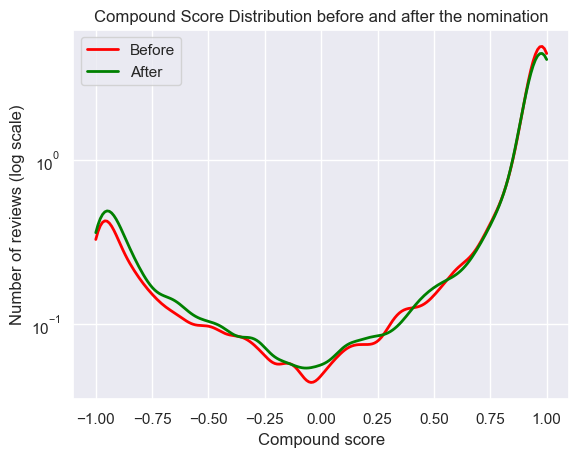

Kolmogorov-Smirnov test p-value: 0.0027757930220719145


In [2]:
oscar_bump.plot_compound_distribution(type_="nomination")

The plot shows that most reviews are either very negative or very positive, with a higher number of positive reviews compared to negative ones. The distribution appears to remain the same before and after the nomination.

People seem to have very polarized opinions. A movie is either a masterpiece or complete garbage!

However, when performing a Kolmogorov-Smirnov test on the two distribution, we have a p-value smaller than 0.05. Thus we reject the null hypothesis that the distributions are the same! This means that we cannot say that the average scores do not stay unchanged.


To see the difference in the compound score further, we trained a regression model using the compound scores from positive, negative, and global reviews, both before and after the nomination. The goal of this analysis is to assess whether there is a significant shift in the mean of the scores before and after this event and what it looks like.

In [3]:
final_df_positive = oscar_bump.perform_regression_compound(type_score="positive", type_date="nomination")

                            OLS Regression Results                            
Dep. Variable:               compound   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.02519
Date:                Fri, 20 Dec 2024   Prob (F-statistic):              0.874
Time:                        15:49:15   Log-Likelihood:                 4630.1
No. Observations:               15304   AIC:                            -9256.
Df Residuals:                   15302   BIC:                            -9241.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8966      0.002    438.596      0.0

Based on this regression, we can see that the change in positive scores is not significant (P-Value > 0.05). This suggests that the positive reviews after the nomination remain just as positive as they were before (there is only a shift of 0.0005 in the score after the nomination).

In [4]:
final_df_negative = oscar_bump.perform_regression_compound(type_score="negative", type_date="nomination")

                            OLS Regression Results                            
Dep. Variable:               compound   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6538
Date:                Fri, 20 Dec 2024   Prob (F-statistic):              0.419
Time:                        15:49:46   Log-Likelihood:                -388.61
No. Observations:                3122   AIC:                             781.2
Df Residuals:                    3120   BIC:                             793.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7168      0.007   -103.308      0.0

Like in the case of the positive reviews, we can observe that the change in negative scores is not significant (P-Value > 0.05). This suggests that the negative reviews after the nomination remain just as negative as they were before (there is only a shift of -0.0079 in the score after the nomination).

In [5]:
final_df = oscar_bump.perform_regression_compound(type_date="nomination")

                            OLS Regression Results                            
Dep. Variable:               compound   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     15.44
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           8.54e-05
Time:                        15:52:30   Log-Likelihood:                -17387.
No. Observations:               18412   AIC:                         3.478e+04
Df Residuals:                   18410   BIC:                         3.479e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6587      0.006    101.588      0.0

When considering all reviews (both positive and negative), the resulting p-value of the regression is very small (p < 0.05). This indicates that compound scores significantly decreased after the nomination.

From the two previous tests, we know that the positive and negative compound scores do not change. A plausible explanation for this result could be that a higher number of negative reviews and/or fewer positive reviews are published after the nomination. This shift in review composition lowers the mean compound score, which in this case is -0.036.

To better understand this phenomenon, let’s plot the distributions of the compound scores under different conditions:

- Neutral: Compound score < 0.2
- Positive: Compound score > 0.2
- Really positive: Compound score > 0.8
- (The same thresholds apply to classify negative reviews.)

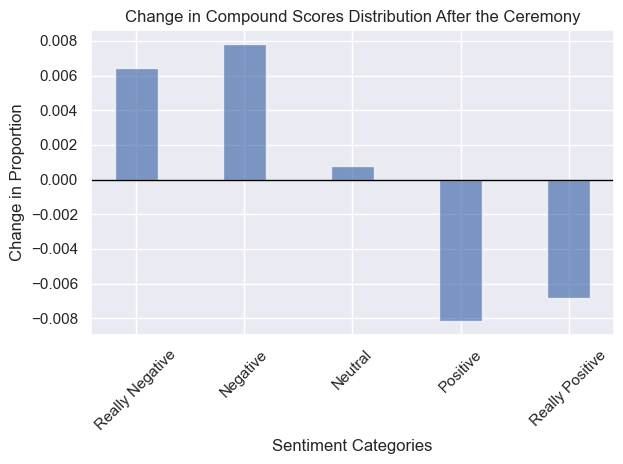

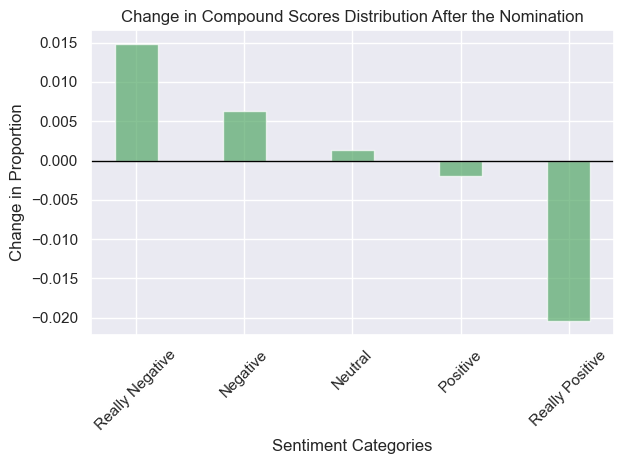

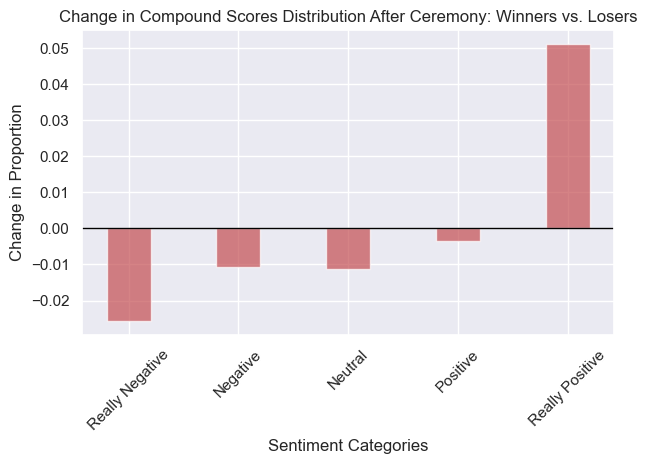

In [6]:
oscar_bump.plot_proportions_change()

We observe that each major event (nomination and ceremony) results in an increase in the number of negative reviews. This effect is more pronounced in the case of the nomination.

The final plot reveals that winning movies receive a higher proportion of "Really Positive" reviews and fewer "Really Negative" ones. Interestingly, these movies do not show a larger proportion of "Positive" reviews. This suggests that the positive feedback is more "extreme," with reviewers strongly emphasizing the quality of the winning films.

So far, our tests have been conducted on a global scale. However, can this difference in compound scores also be observed when reviews are grouped by movie? To explore this, we will perform the Wilcoxon test, which assesses whether two distributions are identical, for each individual movie. Specifically, we aim to determine if the review score distributions before and after the nomination or ceremony date are similar.

In [7]:
result_df_nomination = oscar_bump.perform_statistical_test_compound(type_="nomination")

There are 8 rejected movies (p-value < 0.05). That represents only 12.121212121212121 percent of the movies


In [8]:
result_df_ceremony = oscar_bump.perform_statistical_test_compound(type_="ceremony")


There are 5 rejected movies (p-value < 0.05). That represents only 7.575757575757576 percent of the movies


It appears that significant differences between the score distributions are relatively rare. This suggests that, for most individual movies, the compound scores tend to remain consistent, even after a nomination.

Interestingly, we observe that there are more movies with significant differences after the nomination than after the ceremony. This implies that the nomination generates a larger "buzz" and has a stronger impact on public engagement compared to the ceremony itself. The nomination might act as a catalyst, sparking more engagement and discussions among viewers.

But what about the distinction between winning and non-winning movies? Does receiving an award lead to significant changes in the compound score more frequently? To investigate this, let’s compare the impact of awards on review distributions for winning and non-winning movies.

In [9]:
# Winning movies
result_df_ceremony.loc[(result_df_ceremony['Winner'] == True)].shape[0]

9

In [10]:
# Loosing movies
result_df_ceremony.loc[(result_df_ceremony['Winner'] == False)].shape[0]

57

In [11]:
# 1 / 9 =  11.11%
result_df_ceremony.loc[(result_df_ceremony['Winner'] == True) & (result_df_ceremony['p-value'] < 0.05)]

,Movie ID,Winner,p-value
50,tt1024648,True,0.041748


In [12]:
# 4 / 57 = 7.02%
result_df_ceremony.loc[(result_df_ceremony['Winner'] == False) & (result_df_ceremony['p-value'] < 0.05)]

,Movie ID,Winner,p-value
7,tt0167261,False,0.048062
10,tt0190332,False,0.008090
44,tt0947798,False,0.039597
45,tt0970179,False,0.019484


The percentage of rejected tests (i.e., cases showing a significant difference in the compound score distributions) is higher for winning movies compared to losing ones. This indicates that Oscar-winning movies are more likely to experience a change in the average compound score. This shift could be attributed to the heightened attention and discussion generated by their success.

Winning an Oscar often draws a more polarized response from viewers, leading to a measurable impact on the compound score. On the other side, losing movies tend to maintain more stable compound scores, possibly because they lack the same surge of public interest.

Having completed these tests, the next step is to visualize how the compound scores and review counts evolve over time. By plotting these two metrics on a timeline, we can better understand the dynamics of the audience engagement during key events, such as nominations and awards ceremonies.

Let’s begin by focusing on a single movie:

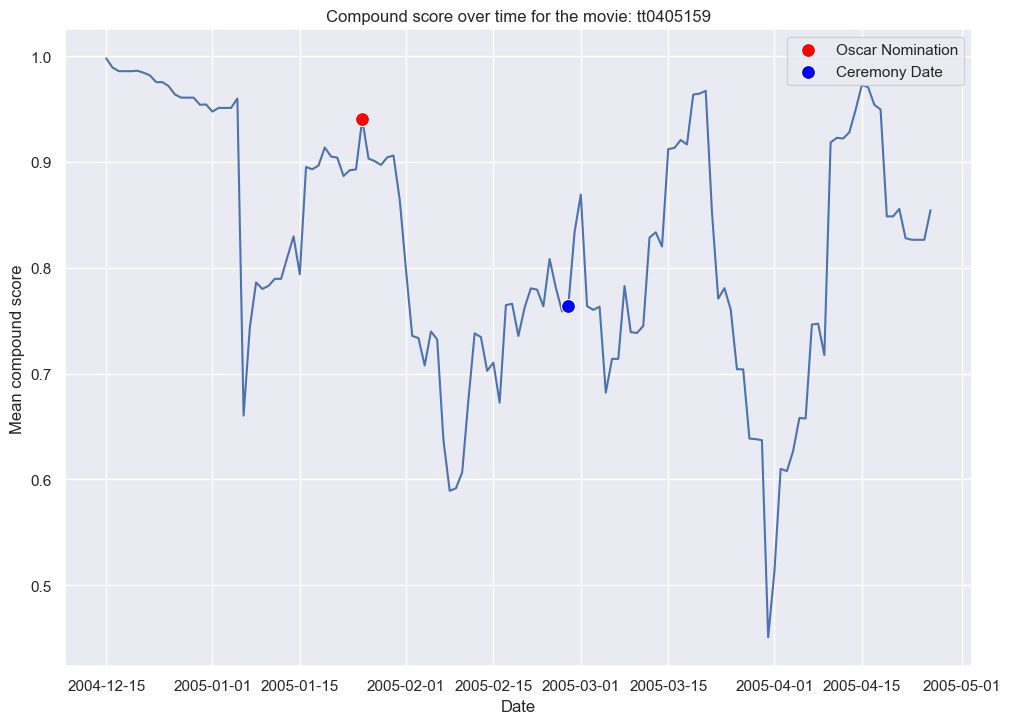

In [14]:
oscar_bump.plot_oscar_bump_unique_movie('tt0405159',"compound")

The timeline shows considerable fluctuation. This is likely due to the fact that the average score for a single day is based on only a small number of reviews. With such limited data points, the daily scores become highly volatile, leading to sharp changes from one day to the next.

As a result, the timeline can be difficult to interpret, as these day-to-day variations may not reflect meaningful trends but rather random noise caused by the low volume of reviews.

To address this, we might consider averaging the data over multiple movies to smooth out the fluctuations and reveal more consistent patterns.

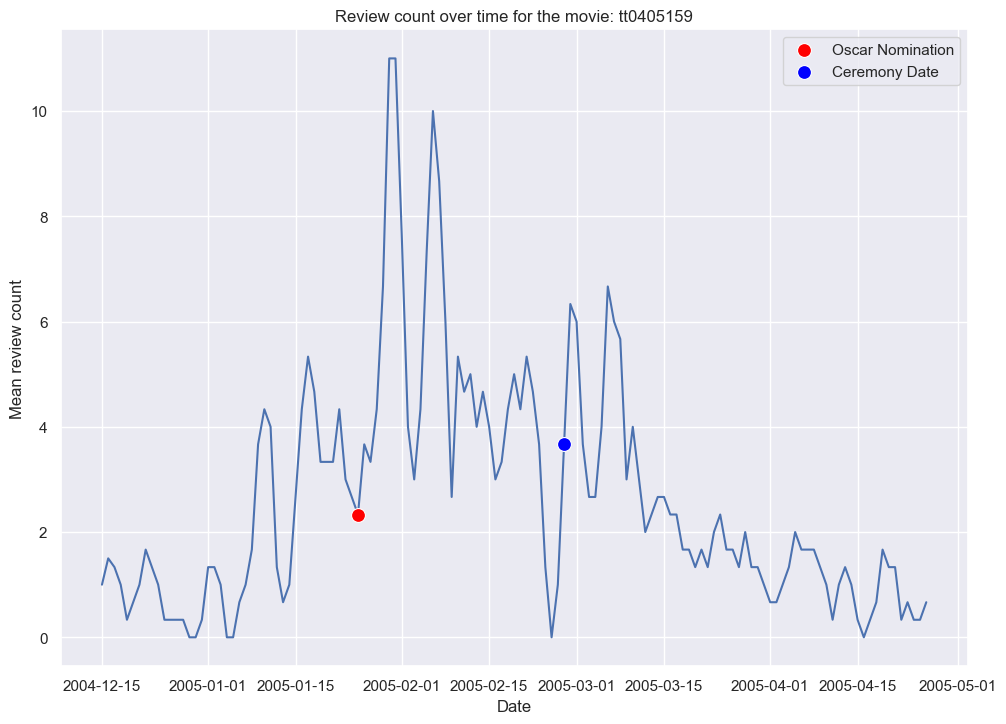

In [15]:
oscar_bump.plot_oscar_bump_unique_movie('tt0405159',"count")

The timeline reveals two distinct spikes in the number of reviews, one occurring shortly after the nomination and another following the ceremony. These surges suggest that both events attract heightened attention and engagement from viewers. However, the number of reviews appears to decline rapidly after the ceremony, indicating a drop in public interest once the awards season concludes.

These patterns are quite interesting! Now that we’ve explored the timeline for a single movie, let’s extend this analysis to all the movies and examine whether similar trends hold across the dataset. Time 0 is the ceremony date.

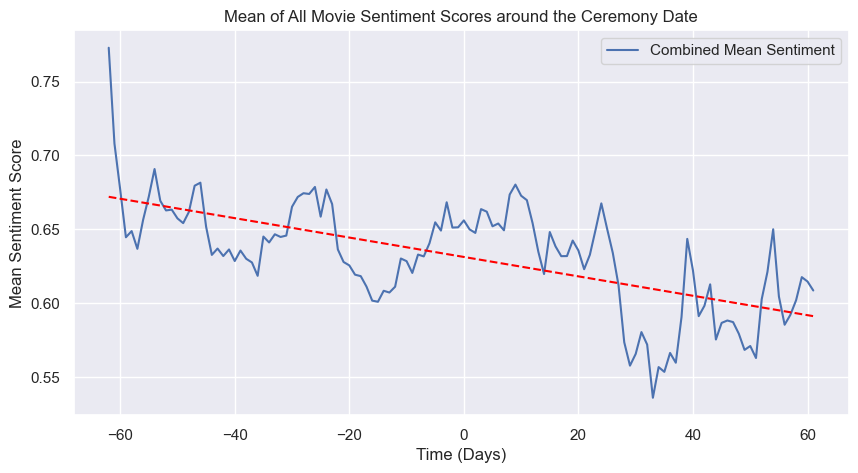

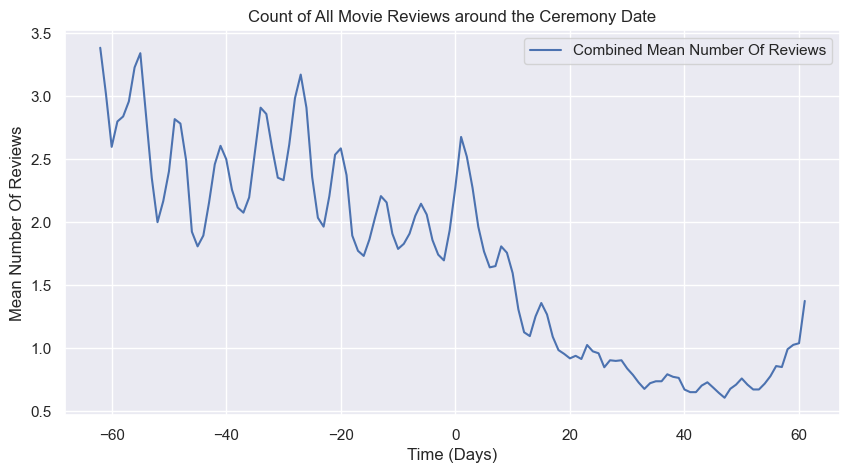

In [16]:
oscar_bump.plot_oscar_bump_all_movies()

A clear trend emerges where the mean compound score of nominated movies worsens over time. In other words, the number of negative reviews increases, which aligns with the often critical nature of online websites. It seems that as movies gain more visibility, they also attract more "haters."

We also observe that the number of reviews drops sharply after the ceremony. The hype appears to peak between the nomination and the ceremony, with one final surge in activity immediately following the awards. After this brief post-ceremony spike, engagement rapidly declines, suggesting that public interest fades quickly once the event is over.

## 5. Oscars jury preferences

Is there a secret formula to be nominated at the Oscars?

We would like to see if the jury nominating movies for the "Best Picture" category have special tastes. To do so, we start by taking a closer look at the genres of the movies nominated by the jury.

For this analysis, we will use data from CMU dataset, in union with all movies nominated for "Best Picture" and the boolean feature "nominated".

In [3]:
data = jury_bias.load_data()

### Genres

First, we plot the distribution of genres for the movies nominated for the "Best Picture" category and compared it to the distribution of genres for all the movies in the dataset.

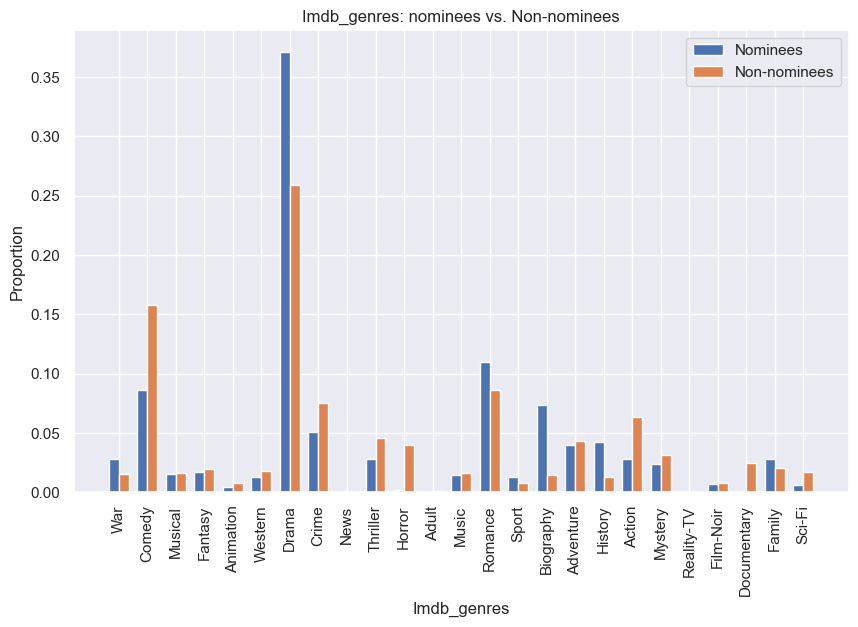

In [35]:
jury_bias.plot_categorical_distribution(data, "IMDB_genres")

We can see that the two distributions are quite different, indicating a possible preference of the jury for certain genres. However, the visualization is not very clear and it is difficult to determine which genres are preferred by the jury.
Though we can see clear difference for some genres like Drama and Biography, the current genre distribution visualization for Oscar winners/nominees versus other films is dominated by the Drama genre, overshadowing differences in less prevalent genres and making it difficult to determine if the Oscar jury has a clear preference for certain genres.

To gain clearer insights, we perform an Ordinary Least Squares regression to determine the impact of each genre on the probability of a movie being nominated for the "Best Picture" category.

It will be applied on a balanced dataset and filter out features with high VIF to avoid multicollinearity.

In [36]:
jury_bias.ols_categorical(data, "IMDB_genres")

                            OLS Regression Results                            
Dep. Variable:              nominated   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     804.8
Date:                Fri, 20 Dec 2024   Prob (F-statistic):               0.00
Time:                        16:33:11   Log-Likelihood:                -31194.
No. Observations:               54790   AIC:                         6.244e+04
Df Residuals:                   54764   BIC:                         6.267e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0293      0.007      4.183      

We notice issues with residual normality and autocorrelation:
1. Omnibus and Jarque-Bera tests:  
   - High values indicate non-normality of residuals, suggesting potential violations of model assumptions.

2. Durbin-Watson (0.516):  
   - Indicates moderate autocorrelation in residuals, which might affect the validity of the regression.

3. Condition Number (224):  
   - Suggests some multicollinearity among predictors, but not severe enough to invalidate the results.


Therefore, we will use GLS regression for our analysis. GLS is a more appropriate modeling approach as it accounts for autocorrelation and heteroscedasticity in the residuals, ensuring more reliable and robust estimates.
It will also be applied on a balanced dataset and filter out features with high VIF to avoid multicollinearity.


                            GLS Regression Results                            
Dep. Variable:              nominated   R-squared:                       0.269
Model:                            GLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     804.8
Date:                Fri, 20 Dec 2024   Prob (F-statistic):               0.00
Time:                        16:33:17   Log-Likelihood:                -31194.
No. Observations:               54790   AIC:                         6.244e+04
Df Residuals:                   54764   BIC:                         6.267e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0293      0.007      4.183      

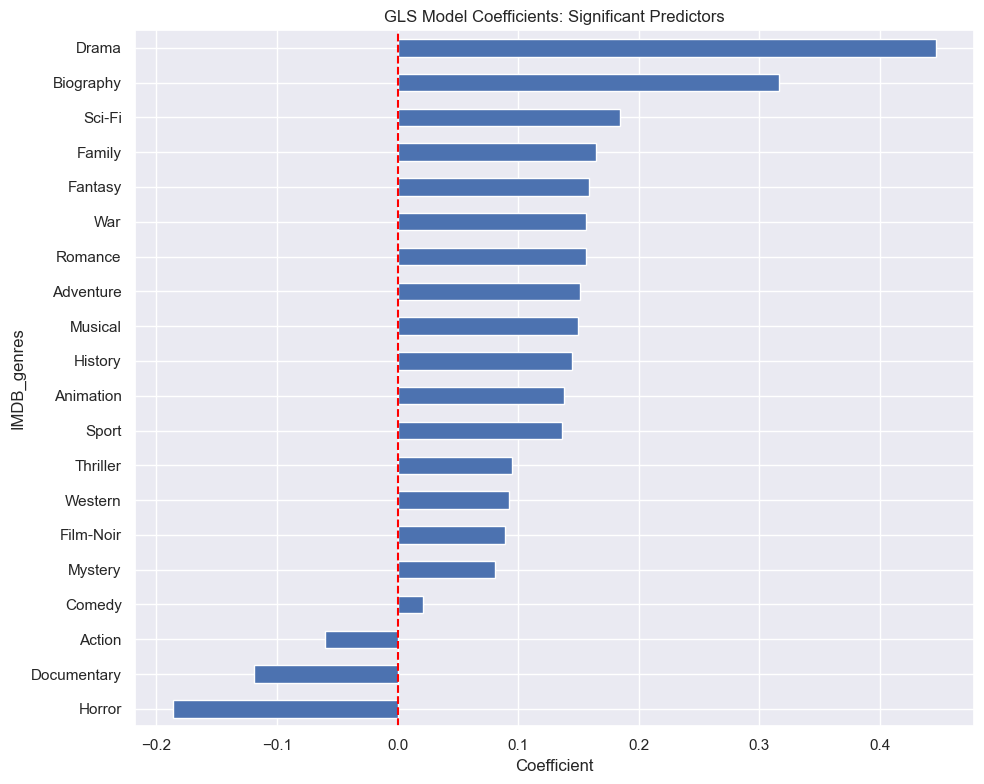

In [37]:
jury_bias.gls_categorical(data, "IMDB_genres")


**Model Fit**
1. **R-squared**: 0.269. Indicates that 26.9% of the variance in the dependent variable (`nominated`) is explained by the predictors. This shows meaningful explanatory power for the model.
2. **Adj. R-squared**: 0.268. Adjusted for the number of predictors, this value confirms the model's overall strength.
3. **F-statistic**: 804.8 (p-value: 0.00). Indicates that the overall regression is highly statistically significant, and the predictors collectively have a meaningful impact.

**Coefficients**
Each coefficient represents the effect of that feature on the probability of being nominated, holding other predictors constant.

1. **Significant Predictors (p < 0.05):**
   - **Adventure**: Positive effect (**0.1516**), highly significant (p = 0.000).
   - **Animation**: Positive effect (**0.1383**), highly significant (p = 0.000).
   - **Biography**: Strong positive effect (**0.3162**), highly significant (p = 0.000).
   - **Comedy**: Positive effect (**0.0206**), significant (p = 0.000).
   - **Drama**: Strong positive effect (**0.4463**), highly significant (p = 0.000).
   - **Family**: Positive effect (**0.1644**), highly significant (p = 0.000).
   - **Documentary**: Negative effect (**-0.1194**), highly significant (p = 0.000).
   - **Action**: Negative effect (**-0.0601**), highly significant (p = 0.000).

   These results suggest that genres such as Drama, Biography, and Family are strongly associated with nominations, while genres like Documentary and Action show significant negative effects.

2. **Non-significant Predictors (p > 0.05):**
   - **Adult** and **Crime** do not show a statistically significant effect on the likelihood of being nominated.

3. **Constant (Intercept):**
   - Coefficient: **0.0293**  
     - Suggests a baseline positive probability of nomination when all predictors are zero. This is statistically significant (p = 0.000).

**Conclusion**
- The model is statistically significant and explains a meaningful fraction of the variance in nominations (**R-squared ~ 0.269**).
- Genres such as Drama, Biography, and Family show strong positive associations with nominations, while Documentary, Action and Horror show significant negative effects.
- Non-significant predictors like Adult and Crime have limited explanatory power in this model.



For the next features, we will directly perform Generalized Least Squares (GLS) regression instead of Ordinary Least Squares (OLS). This decision is based on the findings from the OLS regression on genres, countries and runtime, which revealed several issues:
- Strong autocorrelation (Durbin-Watson statistic).
- Non-normal residual distribution (Jarque-Bera test).
Given these consistent issues, GLS is a more appropriate modeling approach as it accounts for autocorrelation and heteroscedasticity in the residuals, ensuring more reliable and robust estimates.

If you would like to see the OLS regression results for comparison, you can uncomment the relevant code provided in the notebook.

### Countries

We proceed in the same way for the countries of production of the movies. Because there are many countries, we only consider the 20 most represented countries in the dataset. This should be enough to compare distributions.

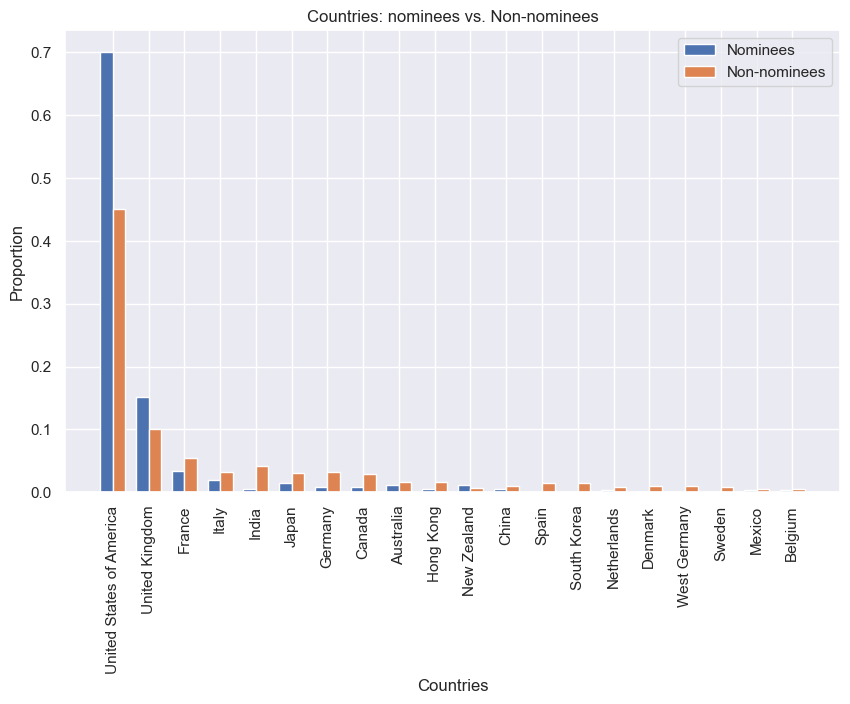

In [39]:
jury_bias.plot_categorical_distribution(data, "countries", 20)

In [70]:
top_country = data[data['nominated']]['countries'].value_counts().idxmax()
top_country_data = data[data['countries'].str.contains(top_country)]
number_nomination = top_country_data[top_country_data['nominated']].shape[0]

print("Country with the most nominations: ", top_country)
print(f"Number of nominations for the {top_country}: ", number_nomination)

Country with the most nominations:  United States of America
Number of nominations for the United States of America:  255


From the comparison of distribution, it looks like movies from the United States are favored by the jury. To gain more insights, we perform a GLS regression to determine the impact of each country on the probability of a movie being nominated for the "Best Picture" category.

In [15]:
# jury_bias.ols_categorical(data, "countries")

                            GLS Regression Results                            
Dep. Variable:              nominated   R-squared:                       0.245
Model:                            GLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     133.3
Date:                Fri, 20 Dec 2024   Prob (F-statistic):               0.00
Time:                        17:55:30   Log-Likelihood:                -32070.
No. Observations:               54790   AIC:                         6.441e+04
Df Residuals:                   54656   BIC:                         6.560e+04
Df Model:                         133                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

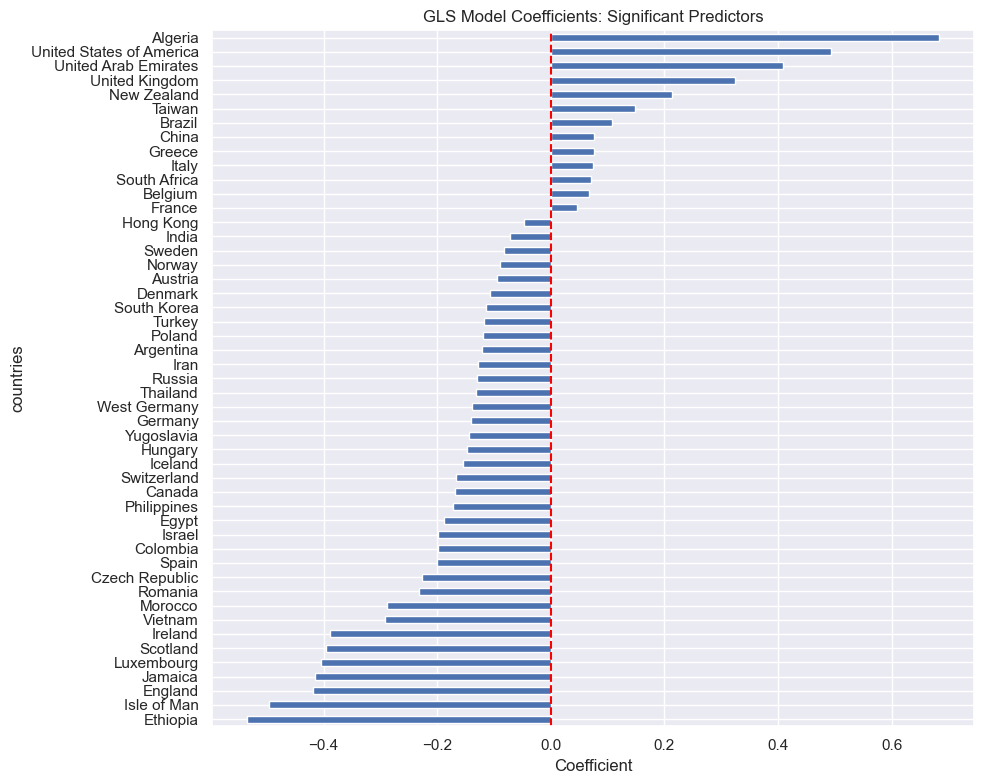

In [3]:
jury_bias.gls_categorical(data, "countries")

**Model Fit**
1. **R-squared**: 0.245. Indicates that 24.5% of the variance in the dependent variable (`nominated`) is explained by the predictors. This shows meaningful explanatory power for the model.
2. **Adj. R-squared**: 0.243. Adjusted for the number of predictors, this value confirms the model's overall strength.
3. **F-statistic**: 133.3 (p-value: 0.00). Indicates that the overall regression is highly statistically significant, and the predictors collectively have a meaningful impact.

**Coefficients**
Each coefficient represents the effect of that country on the probability of being nominated, holding other predictors constant.

1. **Significant Predictors (p < 0.05):**
   - **Algeria**: Strong positive effect (**0.6837**), highly significant (p = 0.000).
   - **Argentina**: Negative effect (**-0.1214**), highly significant (p = 0.000).
   - **Austria**: Negative effect (**-0.0946**), significant (p = 0.029).

   These results suggest that countries such as Algeria have strong positive associations with nominations, while countries like Argentina and Austria show significant negative effects.

2. **Non-significant Predictors (p > 0.05):**
   - Examples include Afghanistan, Albania, and Australia, which do not show a statistically significant effect on the likelihood of being nominated.

3. **Constant (Intercept):**
   - Coefficient: **0.1067**  
     - Suggests a baseline positive probability of nomination when all predictors are zero. This is statistically significant (p = 0.000).


**Conclusion**
- The model is statistically significant and explains a meaningful fraction of the variance in nominations (**R-squared ~ 0.245**).
- Countries like Algeria show strong positive associations with nominations, while Argentina and Austria exhibit significant negative effects.


We were expecting to see the United states on top with their 204 nominations, but Algeria is the most favored country by the jury. This is quite surprising and we would need to investigate further to understand why.

In [56]:
display(data[data['countries'].str.contains("Algeria")])

,tconst,primaryTitle,IMDB_genres,averageRating,numVotes,release,revenue,runtime,countries,oscar_category,oscar_year,nominated
105,tt0065234,z,"Crime,Drama,Thriller",8.1,31944,1969.0,14283305.0,127.0,"France,Algeria,Greece",best picture,1970.0,True
445,tt0856256,peuple en marche,Documentary,8.4,14,1963.0,NaN,55.0,Algeria,NaN,NaN,False
3182,tt0072782,chronicle of the years of fire,"Drama,History",7.3,650,1975.0,NaN,177.0,Algeria,NaN,NaN,False
6456,tt1024188,cartouches gauloises,Drama,6.9,200,2007.0,NaN,92.0,"France,Algeria",NaN,NaN,False
6775,tt0318011,rachida,Drama,6.9,407,2002.0,NaN,100.0,"France,Algeria",NaN,NaN,False
10443,tt1229381,outside the law,"Crime,Drama,War",6.6,4159,2010.0,NaN,137.0,"France,Belgium,Italy,Algeria,Tunisia",NaN,NaN,False
10882,tt0196528,"eldridge cleaver, black panther","Biography,Documentary",6.5,58,1970.0,NaN,75.0,"France,Algeria",NaN,NaN,False
11467,tt0170758,the winds of the aures,"Drama,War",6.5,122,1966.0,NaN,95.0,Algeria,NaN,NaN,False
13781,tt0799932,barakat!,Drama,6.3,153,2006.0,NaN,94.0,"France,Algeria",NaN,NaN,False
15378,tt2399515,the repentant,"Crime,Drama",6.1,192,2012.0,NaN,87.0,"France,Algeria",NaN,NaN,False


#### Why Algeria Has a Large Coefficient
1. Small Sample Size:
Only 14 movies are included, and Z winning an Oscar heavily skews the results. The model interprets this as a strong positive association.
2. Collaborations:
If Algeria collaborates with countries that frequently produce nominated movies, this can amplify the influence. For example, if Z was co-produced with a high-performing country like France, it might create a misleading relationship.
OLS Sensitivity to Outliers:
3. Ordinary Least Squares (OLS) minimizes squared errors, making it sensitive to outliers or influential observations like Z. This skews the coefficient upwards for Algeria.


### Runtime

Finally, we will analyze the impact of the runtime on the nomination like we did for genres and countries.

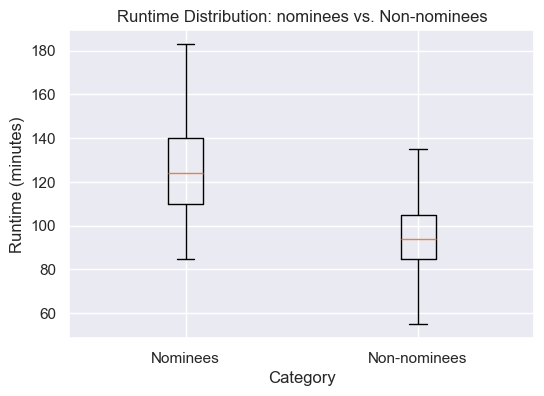

In [4]:
jury_bias.plot_runtime_distribution(data)

The jury seems to prefer longer films, lasting on average 120 minutes. Let's confirm this with a GLS regression.

In [18]:
# jury_bias.ols_continuous(data, "runtime")

In [19]:
jury_bias.gls_continuous(data, "runtime")

                            GLS Regression Results                            
Dep. Variable:              nominated   R-squared:                       0.190
Model:                            GLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                 1.282e+04
Date:                Fri, 20 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:57:13   Log-Likelihood:                -34007.
No. Observations:               54790   AIC:                         6.802e+04
Df Residuals:                   54788   BIC:                         6.804e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1708      0.006    -27.422      0.0


**Model Fit**
1. **R-squared**: 0.190. Indicates that 19.0% of the variance in the dependent variable (`nominated`) is explained by runtime. This shows moderate explanatory power for the model.
2. **Adj. R-squared**: 0.190. Adjusted for the number of predictors, this value confirms the model's overall consistency.
3. **F-statistic**: 12820.0 (p-value: 0.00). Indicates that runtime has a highly statistically significant impact on nominations.

**Coefficients**
Each coefficient represents the effect of the runtime on the probability of being nominated.

1. **Significant Predictor:**
   - **Runtime**: Positive effect (**0.0059**), highly significant (p = 0.000).
     - This suggests that an increase in runtime is associated with a higher probability of being nominated.

2. **Constant (Intercept):**
   - Coefficient: **-0.1708**
     - Suggests a baseline negative association with nominations when runtime is zero. This is statistically significant (p = 0.000).

**Conclusion**
- The model is statistically significant and explains a moderate fraction of the variance in nominations (**R-squared ~ 0.190**).
- Runtime has a small but positive effect on the likelihood of being nominated, as evidenced by its significant coefficient (**0.0059**).


Genre, country of production and runtime seem to play a significant role in the nomination of a movie for the "Best Picture" category. The jury seems to have a preference for certain genres and countries, while the runtime also appears to influence the likelihood of being nominated.
Let's see if we can build a model that predicts the nomination of a movie based on those features.

### Logistic Regression

We chose logistic regression because the target variable is binary (nominated or not nominated) and the predictors are a mix of categorical and continuous variables. Logistic regression is well-suited for this type of classification problem.
Moreover, logistic regression provides interpretable coefficients that allow us to understand the impact of each feature on the probability of being nominated.
The model uses balanced data to ensure equal representation of nominated and non-nominated movies, preventing bias in the predictions.

Because the dataset is very imbalanced, we used SMOTE to balance it. This technique generates synthetic samples for the minority class (nominated movies) to create a more balanced dataset for training the model.

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.90      0.95      5479
        True       0.07      0.68      0.12        57

    accuracy                           0.90      5536
   macro avg       0.53      0.79      0.54      5536
weighted avg       0.99      0.90      0.94      5536

ROC-AUC Score: 0.8748138826716361


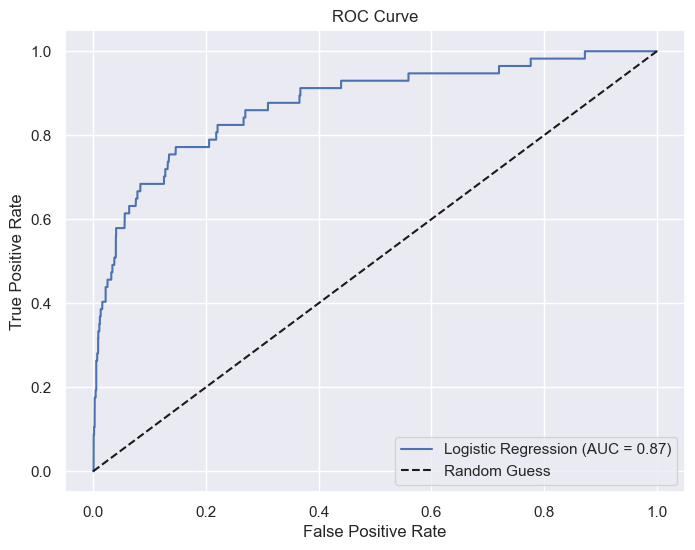

LogisticRegression(max_iter=1000, random_state=42)

In [51]:
feature_columns = ["IMDB_genres", "countries", "runtime"]
jury_bias.logistic_regression(data, feature_columns, "nominated")


#### **Analysis of Results**

**1. Class-Level Metrics**
- **False (Not Nominated)**:
  - Precision: **1.00**
    - The model perfectly identifies true negatives (non-nominated movies).
  - Recall: **0.90**
    - The model captures 90% of the actual non-nominated movies, which is strong.
  - F1-Score: **0.95**
    - The high F1-score reflects a balance between precision and recall for the majority class.

- **True (Nominated)**:
  - Precision: **0.07**
    - Only 7% of the predictions for nominations are correct. This indicates that most predicted nominations are false positives.
  - Recall: **0.68**
    - The model correctly identifies 68% of the actual nominations. This suggests that the model is reasonably sensitive to the minority class.
  - F1-Score: **0.12**
    - The low F1-score reflects the imbalance between precision and recall.

**2. Overall Metrics**
- **Accuracy: 90%**
  - The model is correct 90% of the time, but this metric is misleading due to the imbalance in class distribution.

- **Macro Average**:
  - Precision: **0.53**
  - Recall: **0.79**
  - F1-Score: **0.54**
    - These metrics indicate that the model favors recall over precision, especially for the minority class.

- **Weighted Average**:
  - Precision: **0.99**
  - Recall: **0.90**
  - F1-Score: **0.94**
    - Weighted averages are heavily influenced by the majority class (`False`), which skews these metrics.

**3. ROC-AUC: 0.87**
- The ROC-AUC score of 0.87 suggests that the model is fairly good at distinguishing between the two classes overall. However, this doesn’t directly translate into strong predictive accuracy for the minority class (`True`).


**Conclusion**
The model struggles to predict nominations effectively using only genres, countries, and runtime. While it performs well for non-nominated movies, its low precision for nominations makes it impractical for reliable predictions.


Let's see if we can take into account evolving tastes over time by adding the year of release as a feature.

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.91      0.95      5479
        True       0.07      0.67      0.13        57

    accuracy                           0.91      5536
   macro avg       0.53      0.79      0.54      5536
weighted avg       0.99      0.91      0.94      5536

ROC-AUC Score: 0.8773338712724501


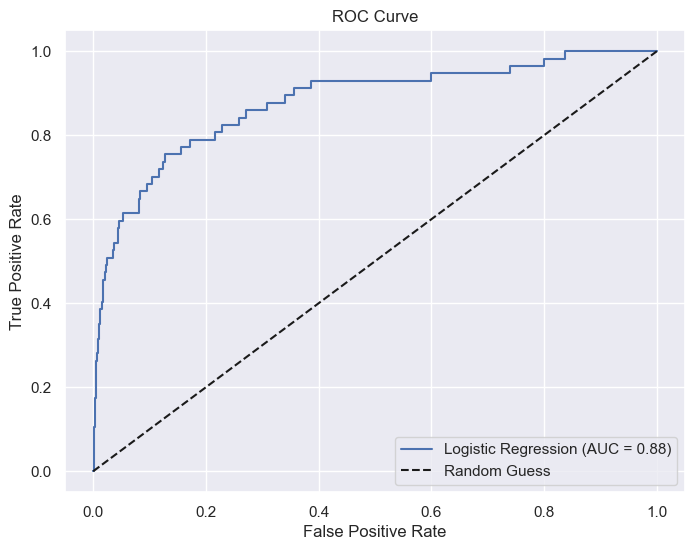

LogisticRegression(max_iter=1000, random_state=42)

In [52]:
feature_columns = ["IMDB_genres", "countries", "runtime", "release"]
jury_bias.logistic_regression(data, feature_columns, "nominated")

Including the release year does not significantly improve the model's ability to predict nominations.

Despite the significance of some coefficients and the amount of variance in GLS regression , the overall predictive power remains limited. The model struggles to accurately predict nominations, especially for the minority class (`True`), due to the imbalanced dataset and the complexity of the nomination process.
This shows that there is no recipe for success at the Oscars, too bad!